In [7]:
import hashlib
import pandas as pd
import seaborn as sns
from ch import Getch
import numpy as np
from scipy import stats
import swifter



## Гипотеза


#### К нам пришла команда ML с новыми алгортимами рекомандаций. Задача сделать пользователей 'счастливее'. Они утверждают, что рекомендации делают посты интереснее


Нам нужна метрика, которая показывает, что посты стали действительно интереснее.  
Возьмем CTR, потому что она отражает заинтересованность- лайки и понятно интерпретируется.  
***H0: CTR после применения теста не изменился***      
***H1: CTR после применения теста значимо изменился*** 

CTR = (посты, которым поставили лайк)  / (все просмотры)

## Делим пользователей на группы

### Cистема сплитования

Требования к группам пользователей :
* Мы хотим, чтобы разбиение было ***случайным***. Делается это для того, чтобы воздействие на них оказывалось *только* в рамках самого теста и *больше ничего*
* Группа должна не меняться в течение эксперимента. Если группа не будет сохраняться и человек будет скакать из одной группы в другую, то он увидит два алгоритма и испортит пункт выше. Более того, не совсем понятно, как нужно будет потом отслеживать эффект на метрику.  
Идеально, если две группы отличаются **только** алгоритмом и больше ничем
* Мы должны иметь возможность повторить ***то же самое разбиение*** (когда нам это понадобится). Если мы захотим проверить еще одну функционалость рекомендаций, то мы должны будем исключить из группы тех, кто эксперимент уже видел. Без детерменированности это будет сделать очень трудно

#### Как побить пользователей на группы 

Рассмотрим классический пример хеширования с солью :



In [8]:
def ab_split(user_id, salt = 'value', n_groups = 5): # разбиение пользователей на n групп
    test_id = str(user_id) + '-' + str(salt)  # склеиваем в единую строку
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()  #перевод строки в число с Равномерным распределением
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

Результат кода выше - детерминированный (всегда будет получаться то же разбиение)

In [9]:
# Рассмотрим пример
q = Getch("""
SELECT distinct user_id
FROM simulator_20220320.feed_actions
WHERE (toDate(time) BETWEEN '2022-03-08' and '2022-03-14')
""")
# Вытащили пользователей
users_df = q.df
users_df1 = q.df.copy()

# Сделали группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/42585 [00:00<?, ?it/s]

,hash_group,user_id
0,0,8439
1,1,8546
2,2,8438
3,3,8492
4,4,8670


In [10]:
print(len(users_df1))

42585


Мы видим, что группы разбились равномерно по хешу

#### Проведение A/A теста

После того, как мы побили на группы пользователей, надо проверить, являются ли они статистически эквивалентными.  
Для этого нужно провести А/A тест.   
Проверить, что группы между собой не отличаются до тех пор, пока мы не выкатили на них новую функциональность.  
Т.е. если группы до этого были статистически эквиваленты, мы можем утверждать, *что возможно полученное различие в дальнейшем вызвано нашим воздействием*

АА-тест проходил с 8 по 14 марта 2022
АБ-тест с нашими системами рекомендаций проходил с 15 по 21 марта 2022

In [11]:
q = Getch("""
    SELECT exp_group,
           user_id AS users,
           sum(action = 'like') AS likes,
           sum(action = 'view') AS views,
           (likes/views) AS ctr
    FROM simulator_20220320.feed_actions
    WHERE (toDate(time) BETWEEN '2022-03-08' and '2022-03-14') and exp_group in (2,3)
    GROUP BY exp_group, user_id
""")

df = q.df

df.groupby('exp_group').count()

,users,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


#### Проверка корректности системы сплитования

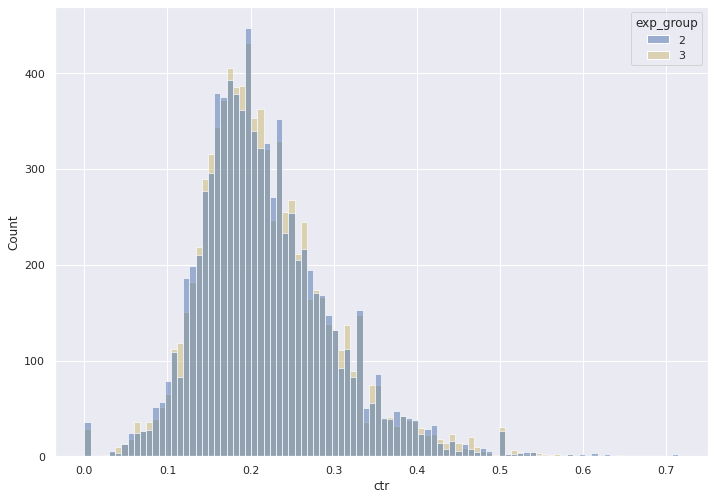

In [12]:

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'y'],
              alpha=0.5,
              kde=False)

Из распределния кажется, что группы статистически эквиваленты и проводить тест можно. Но это проверка на глаз, воспользуемся проверкой тестов

 #### Student`s - T test

Плюсы теста:  
* инетрпретируемый (в отличии от Манна-Уитни) в нашем случае сравниваются средние
* быстро считается 

Минусы теста:
* Если в распределении много выбросов либо оно скошено вправо(влево почти никогда)
* Большие выбросы - часть нашего распределения
* Требуется явная оценка дисперсий групп


In [13]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var= False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

А-А тест сошелся, pvalue очень большое. Наш уровень значимости заданный - 0.05. Здесь он намного выше

Так как мы прошли проверку, не имеет смысла проверять тестом Манна-Уитни. Он чуть менее чувствительный, используется как непараметрический аналог t-test. Но все же проверим :)

#### Манн-Уитни

Плюсы теста:
* не такой требовательный, как t-test
* почти такой же чувствительный
Минусы:
* Так-как здесь у нас ранговая система, он тяжело интерпретируется, но может отслеживать изменчивость, если распределение идентичное, он не должен краситься.  

Нулевая Гипотеза:  
*     Если выборки одинаковые, то тест не будет прокрашиваться.  H0 : P(X > Y) = P(Y > X)
Альтернативная:  
*     Если выборки отличаются, то тест прокрасится               H1 : P(X > Y) != P(Y > X)


In [14]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                         df[df.exp_group == 3].ctr 
                            ))

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)


In [15]:
A_gt_B = 0
for i in range(10000):
    A_gt_B += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]

In [16]:
print('B', A_gt_B/100, '% случаев A > B')  #должно получить в районе 50

B 50.48 % случаев A > B


Бутстрап

In [17]:
group_A = df[df['exp_group'] == 2]
group_B = df[df['exp_group'] == 3]
group_A_frac = 500 / len(group_A)
group_B_frac = 500 / len(group_B)

In [18]:
pval = []
for i in range(10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(frac = group_A_frac, replace = True),
                              group_B.ctr.sample(frac = group_B_frac, replace = True),
                              equal_var = False)
    pval.append(p_value)


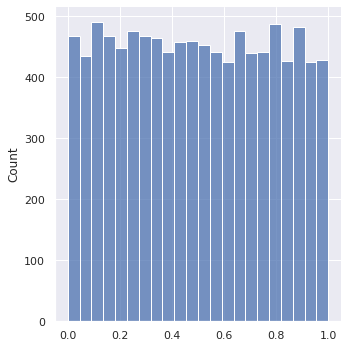

In [19]:
 sns.displot(pval)

In [20]:
 sum(np.array(pval) < 0.05) / 10_000

0.0519

### Вывод

Проведенный А-А тест показывает, что наши выборки статистически эквиваленты. p-value двух групп отклоняется лишь в 5.2% случаев.
Следовательно, на этих группах мы можем проводить A/B тест

# A/B тест

In [26]:
q = Getch("""
    SELECT exp_group,
           user_id AS users,
           sum(action = 'like') AS likes,
           sum(action = 'view') AS views,
           (likes/views) AS ctr
    FROM simulator_20220320.feed_actions
    WHERE (toDate(time) BETWEEN '2022-03-15' and '2022-03-21') and exp_group in (2,1)
    GROUP BY exp_group, user_id
""")
df = q.df

df.groupby('exp_group').count()

,users,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Считаем сглаженный CTR

In [27]:
def get_ctr(user_likes, user_views, global_ctr, alpha):
    return (user_likes + alpha * global_ctr) / (user_views + alpha)

In [28]:
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group ==2].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group ==1].views.sum()

In [30]:
print(global_ctr_2, global_ctr_1)

0.1980601844115994 0.20802680490126244


Вроде бы, отличие есть. Воспользуемся bootstrap-статистикой для проверки гипотезы

In [48]:
def get_bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    bootstrap_1 = stats.poisson(1).rvs((2000, len(likes1))).astype(np.int64)
    bootstrap_2 = stats.poisson(2).rvs((2000, len(likes2))).astype(np.int64)
    global_1 = (bootstrap_1 * likes1).sum(axis=1)/(bootstrap_1 * views1).sum(axis=1)
    global_2 = (bootstrap_2 * likes2).sum(axis=1)/(bootstrap_2 * views2).sum(axis=1)
    return global_1, global_2

In [45]:
q = Getch("""
    SELECT exp_group,
           user_id AS users,
           sum(action = 'like') AS likes,
           sum(action = 'view') AS views,
           (likes/views) AS ctr
    FROM simulator_20220320.feed_actions
    WHERE (toDate(time) BETWEEN '2022-03-15' and '2022-03-21') and exp_group in (2,1)
    GROUP BY exp_group, user_id
""")

likes1 = df[df.exp_group==1].likes.to_numpy()
views1 = df[df.exp_group==1].views.to_numpy()
likes2 = df[df.exp_group==2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [49]:
ctr1, ctr2 = get_bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

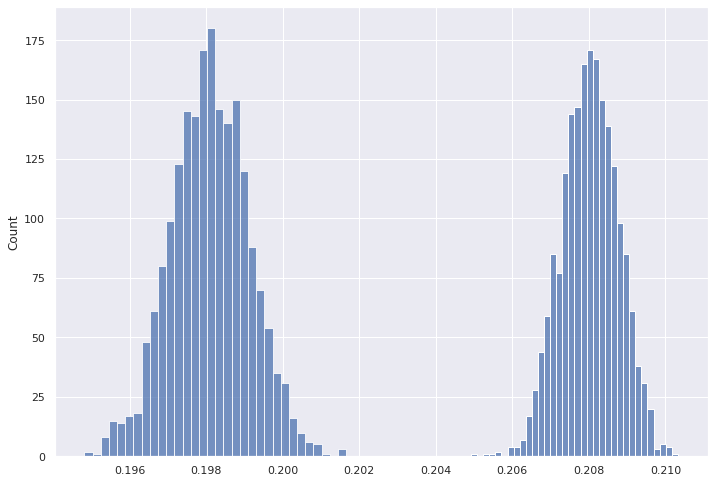

In [50]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Из распределения видно, что значимые отличия есть. Можно раскатывать обновлений на всех пользователей